# Project

In [1]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import neurodynex3.tools.input_factory as input_factory

## Ploting function

In [72]:
def plot_data(state_monitor, title=None):
    """Plots the state_monitor variables ["vm", "I_e", "m", "n", "h"] vs. time.

    Args:
        state_monitor (StateMonitor): the data to plot
        title (string, optional): plot title to display
    """
    states = state_monitor.get_states()
    plots_nb = 4
    p_states = "p" in states.keys()
    if p_states:
        plots_nb += 1
    fig, axs = plt.subplots(plots_nb,1,figsize=(15,plots_nb*3),sharex=True)
    
    i = 0
    # Plot membrane potential
    axs[i].plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2)
    axs[i].set_xlabel("t [ms]")
    axs[i].set_ylabel("v [mV]")
    axs[i].grid()
    i += 1
    
    # Plot Input current
    axs[i].plot(state_monitor.t / b2.ms, state_monitor.I_e[0] / b2.uamp, lw=2)
    axs[i].axis((
        0,
        np.max(state_monitor.t / b2.ms),
        min(state_monitor.I_e[0] / b2.uamp) * 1.1,
        max(state_monitor.I_e[0] / b2.uamp) * 1.1
    ))
    axs[i].set_xlabel("t [ms]")
    axs[i].set_ylabel("I [micro A]")
    axs[i].grid()
    i += 1
    
    # Plot channels parameters
    # Na and K channels 
    axs[i].plot(state_monitor.t / b2.ms, state_monitor.m[0] / b2.volt, "black", lw=2)
    axs[i].plot(state_monitor.t / b2.ms, state_monitor.n[0] / b2.volt, "blue", lw=2)
    axs[i].plot(state_monitor.t / b2.ms, state_monitor.h[0] / b2.volt, "red", lw=2)
    axs[i].set_xlabel("t (ms)")
    axs[i].set_ylabel("act./inact.")
    axs[i].legend(("m", "n", "h"))
    axs[i].axis(ymin=0,ymax=1)
    axs[i].grid()
    i += 1
    
    if p_states:
        axs[i].plot(state_monitor.t / b2.ms, state_monitor.p[0] / b2.volt, "black", lw=2)
        axs[i].set_xlabel("t (ms)")
        axs[i].set_ylabel("act./inact.")
        axs[i].legend(("p"))
        axs[i].axis(ymin=0,ymax=1)
        axs[i].grid()
        i += 1
    
    # Plot Channel current
    axs[i].plot(state_monitor.t / b2.ms, state_monitor.I_Na[0] / b2.uamp, lw=2)
    axs[i].plot(state_monitor.t / b2.ms, state_monitor.I_K[0] / b2.uamp, lw=2)
    axs[i].axis((
        0,
        np.max(state_monitor.t / b2.ms),
        min(min(state_monitor.I_Na[0] / b2.uamp),min(state_monitor.I_K[0] / b2.uamp))* 1.1,
        max(max(state_monitor.I_Na[0] / b2.uamp),max(state_monitor.I_K[0] / b2.uamp))* 1.1
    ))
    axs[i].set_xlabel("t [ms]")
    axs[i].set_ylabel("I [micro A]")
    axs[i].legend(("I_Na", "I_K"))
    axs[i].grid()
    i += 1

    if title is not None:
        plt.suptitle(title)

    plt.show()

## Simulation Functions

In [77]:
def simulate_HH_neuron_regular(input_current, simulation_time):

    """A Hodgkin-Huxley neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h"]
    """
    
    # neuron parameters
    El = -70 * b2.mV
    EK = -90 * b2.mV
    ENa = 50 * b2.mV
    gl = 0.1 * b2.msiemens
    gK = 5 * b2.msiemens
    gNa = 50 * b2.msiemens
    C = 1 * b2.ufarad

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    I_Na = gNa*m**3*h*(ENa-vm) : amp
    I_K = gK*n**4*(EK-vm) : amp
    membrane_Im = I_e + I_Na + gl*(El-vm) + I_K : amp
    alphah = .128*exp(-(vm/mV+43)/18)/ms    : Hz
    alpham = -0.32*(vm+47*mV)/(exp(-.25*(vm/mV+47))-1)/mV/ms : Hz
    alphan = -.032*(vm+45*mV)/(exp(-.2*(vm/mV+45))-1)/mV/ms : Hz
    betah = 4./(exp(-0.2*(vm/mV+20))+1)/ms : Hz
    betam = .28*(vm+20*mV)/(exp(.2*(vm/mV+20))-1)/mV/ms : Hz
    betan = .5*exp(-(vm/mV+50)/40)/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = 0
    neuron.m = 0.05
    neuron.h = 0.60
    neuron.n = 0.32

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "I_Na", "I_K", "m", "n", "h"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

## Pipeline

In [4]:
def getting_started_regular():
    """
    An example to quickly get started with the Hodgkin-Huxley module.
    """
    current = input_factory.get_step_current(10, 45, b2.ms, 7.2 * b2.uA)
    state_monitor = simulate_HH_neuron_regular(current, 70 * b2.ms)
    plot_data(state_monitor, title="HH Neuron, step current")

In [80]:
zero_current = input_factory.get_zero_current()
state_monitor = simulate_HH_neuron_regular(zero_current, 10 * b2.ms)

WARNING    <ipython-input-72-a3c7f6995bf1>:25: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axs[i].axis((
 [py.warnings]


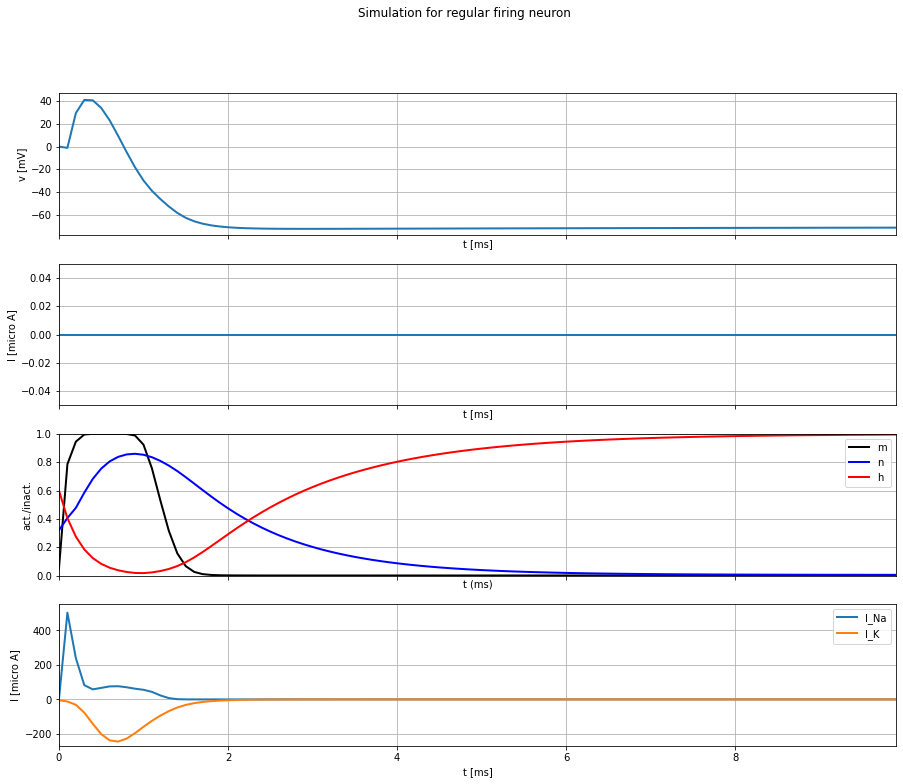

In [81]:
plot_data(state_monitor,"Simulation for regular firing neuron")